## Lab 6: Variable Selection and Regularization

In [1]:
#| echo: false
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv("/Users/ben/Documents/GitHub/DSML/Data/Hitters.csv")
data = data.dropna()
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [231]:
X = data.drop("Salary", axis = 1)
y = data["Salary"]

In [127]:
def create_pipeline(transforms = [], regression = str, remainder = "passthrough", tuning = [], interaction_columns = []):
    """
        Creates the desired pipeline object
        Arguments
        ---------
        transforms: a list of desired steps, must be one or more of ["encode", "standardize", "interaction"]
        regression: a str, must be one of ["linear", "ridge", "lasso", "elastic_net"]
        remainder: a str, whether to drop or passthrough the extra columns, default is passthrough
        tuning: a list of tuning parameters, alpha for ridge and lasso, alpha + l1 for elastic net
        interaction columns: a list of interaction variables, must be names of the columns in dataframe
        
        Returns
        -------
        A sklearn pipeline object
    """
    if regression in ["ridge", "lasso"] and len(tuning) not in [0, 1]:
        raise ValueError(f"Tuning array must have length 0 or 1 for {regression} regression")
    elif regression == "elastic_net" and len(tuning) not in [0, 2]:
        raise ValueError("Tuning array must have length 2 for elastic net regression")
    elif regression not in ["linear", "ridge", "lasso", "elastic_net"]:
        raise ValueError(f"Invalid regression type: {regression} regression")
    
    if "interaction" in transforms and len(interaction_columns) < 1:
        raise ValueError(f"Interaction requires at least one interaction term, you provided: {interaction_columns}")
            
    t_dict = {
        "dummify": ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"), make_column_selector(dtype_include=object)),
        "standardize": ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    }
        # "interaction": ("interact", PolynomialFeatures(interaction_only=True), interaction_columns)

    r_dict = {
        "linear": LinearRegression(),
        "ridge": Ridge(),
        "lasso": Lasso(),
        "elastic_net": ElasticNet()
    }
    transforms = [t_dict[i] for i in transforms]
    
    ct = ColumnTransformer(
        transforms, 
        remainder = remainder
    )
    
    ct_inter = ColumnTransformer(
        [("interaction", PolynomialFeatures(interaction_only=True), make_column_selector(dtype_include=[object, np.number]))],
        remainder = remainder
    )
    
    p = Pipeline(
        [
            ("preprocessing", ct),
            (regression + "_regression", r_dict[regression])
        ]
    ).set_output(transform="pandas")
    
    if len(interaction_columns) >= 1:
        p = Pipeline(
            [
                ("preprocessing", ct),
                ("interaction", ct_inter),
                (regression + "_regression", r_dict[regression])
            ]
        ).set_output(transform="pandas")
    
    if len(tuning) == 1:
        if regression == "ridge":
            p.named_steps[regression + "_regression"].set_params(alpha = tuning[0])
        if regression == "lasso":
            p.named_steps[regression + "_regression"].set_params(alpha = tuning[0])
    elif len(tuning) > 1:
        p.named_steps[regression + "_regression"].set_params(alpha = tuning[0], l1_ratio = tuning[1])
    
    return p

## Part 1: Different Model Specs

#### A. Regression without regularization

In [232]:
my_pipeline = create_pipeline(transforms = ["dummify"], regression = "linear")

fitted_pipeline = my_pipeline.fit(X, y)

coef = fitted_pipeline.named_steps["linear_regression"].coef_
coef = dict(zip(X.columns, coef))
sorted_coef = dict(sorted(coef.items(), key=lambda item: item[1]))
sorted_coef

{'Hits': -116.84924563689971,
 'HmRun': -24.762325108401626,
 'CHmRun': -3.489054263246781,
 'NewLeague': -3.360760479856514,
 'Years': -2.37620998395482,
 'Runs': -1.9798728999519537,
 'CAtBat': -1.044961960975944,
 'PutOuts': -0.8115709106268265,
 'CWalks': -0.17286107024683814,
 'CRuns': -0.17134047309998682,
 'CRBI': 0.13399096143288738,
 'Assists': 0.28189251335823373,
 'Errors': 0.37106921041624474,
 'Division': 0.8077088017035939,
 'League': 1.4543049400842525,
 'Walks': 4.330882897912556,
 'CHits': 6.231286323075296,
 'RBI': 7.500767544663816,
 'AtBat': 62.599423035185886}

After training the model on the sample data, it appears that the most important coefficients are Hits (number of hits in 1986), AtBat (number of times at bat in 1986), HmRun (number of homeruns in 1986), RBI (number of runs batted in in 1986), and CHits (number of hits in player's career). I find the coefficients for Hits and HmRuns to be interesting because they are very negative, which means that the model predicts that a player with more hits and homeruns in 1986 will have a lower salary.

In [233]:
scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

121136.31031816902

#### B. Ridge Regression

In [234]:
alphas = {"ridge_regression__alpha": [.001, .01, .1, 1, 10, 100]}

my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "ridge", tuning = [])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cab9610>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cab7790>)])),
                ('ridge_regression', Ridge(alpha=1))])

In [235]:
my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "ridge", tuning = [1])

fitted_pipeline = my_pipeline.fit(X, y)

coef = fitted_pipeline.named_steps["ridge_regression"].coef_
coef = dict(zip(X.columns, coef))
sorted_coef = dict(sorted(coef.items(), key=lambda item: item[1]))
sorted_coef

{'Runs': -271.0881646126556,
 'CRuns': -225.51164910321808,
 'PutOuts': -184.28940754454507,
 'Hits': -119.07692729806558,
 'CHmRun': -38.61913060407965,
 'Years': -29.21235217885602,
 'HmRun': -24.027205418743865,
 'NewLeague': -23.651302732114033,
 'CAtBat': -8.909303811542419,
 'Walks': 17.97397065895863,
 'CWalks': 39.05534626826766,
 'Errors': 47.49363089559216,
 'AtBat': 58.55594721977789,
 'Assists': 78.65103739848763,
 'CHits': 124.34401181155278,
 'CRBI': 126.21058540712917,
 'Division': 160.40949658616404,
 'RBI': 296.8019666767589,
 'League': 320.80271678721397}

After training the model on the sample data and tuning the hyperparameter $\alpha$, it appears that the most important coefficients to the ridge regression are League (player's league at the end of 1986), RBI (number of runs batted in in 1986), Runs (number of runs in 1986), CRuns (number of runs during player's career), and PutOuts (number of put outs in 1986). I find the division and league coefficients to be the most interesting because it means that it is more important to the model where you play than how you play, in fact the model punishes runs scored the most of any variable for predicting salary.

In [236]:
scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

119034.33271954514

#### C. Lasso Regression

In [237]:
#| warning: false
alphas = {"lasso_regression__alpha": [.001, .01, .1, 1, 10, 100]}

my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "lasso", tuning = [])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.984e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cae3890>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ca05a50>)])),
                ('lasso_regression', Lasso(alpha=1))])

In [238]:
my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "lasso", tuning = [1])

fitted_pipeline = my_pipeline.fit(X, y)

coef = fitted_pipeline.named_steps["lasso_regression"].coef_
coef = dict(zip(X.columns, coef))
sorted_coef = dict(sorted(coef.items(), key=lambda item: item[1]))
sorted_coef

{'Runs': -282.3709571733042,
 'PutOuts': -189.6446419428977,
 'CRuns': -162.63979376863503,
 'Hits': -114.41295113390974,
 'CHmRun': -34.94814807264402,
 'Years': -24.966507111398574,
 'NewLeague': -18.47937839674752,
 'HmRun': -0.0,
 'CAtBat': -0.0,
 'CRBI': 0.0,
 'Walks': 11.12702202936373,
 'CWalks': 14.225993157039015,
 'AtBat': 35.82607211162789,
 'Errors': 41.9966795039537,
 'Assists': 78.7603657545689,
 'CHits': 120.69527502165958,
 'Division': 192.61089166933564,
 'RBI': 304.35950858415066,
 'League': 375.5655192079623}

After training the model on the sample data and tuning the hyperparameter $\alpha$, it appears that the most important coefficients to the lasso regression are League (player's league at the end of 1986), RBI (number of runs batted in in 1986), Runs (number of runs in 1986), Division (player's division at the end of 1986), and PutOuts (number of put outs in 1986). I find the division and league coefficients to be the most interesting because it means that it is more important to the model where you play than how you play, in fact the model punishes runs scored the most of any variable for predicting salary.

In [230]:
#| warning: false
scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

124330.62008404215

#### D. Elastic Net

In [82]:
#| warning: false
alphas = {"elastic_net_regression__alpha": [.001, .01, .1, 1, 10], "elastic_net_regression__l1_ratio": [.001, .01, .1, 1]}

my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "elastic_net", tuning = [])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.229e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x165858150>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x164bd6050>)])),
                ('elastic_net_regression',
                 ElasticNet(alpha=0.01, l1_ratio=0.001))])

In [87]:
#| warning: false
my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "elastic_net", tuning = [.01, .001])

fitted_pipeline = my_pipeline.fit(X, y)

coef = fitted_pipeline.named_steps["elastic_net_regression"].coef_
coef = dict(zip(X.columns, coef))
sorted_coef = dict(sorted(coef.items(), key=lambda item: item[1]))
sorted_coef

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.657e+05, tolerance: 5.332e+03
  model = cd_fast.enet_coordinate_descent(


{'Runs': -234.17147767040674,
 'PutOuts': -156.17557959386082,
 'CRuns': -122.58716096135389,
 'Hits': -119.16979793592333,
 'CHmRun': -49.40538601536679,
 'NewLeague': -24.606294114161706,
 'HmRun': -20.13260424182234,
 'Years': -6.631449298451311,
 'CAtBat': 2.378895534750969,
 'Walks': 5.0660306094090855,
 'Errors': 41.53343419087893,
 'AtBat': 53.1346413834826,
 'CWalks': 55.69046199270078,
 'Assists': 78.03676480115597,
 'CHits': 111.73777926655586,
 'Division': 122.8521518683615,
 'CRBI': 123.1026573090582,
 'League': 227.50599207860876,
 'RBI': 250.24311284349213}

After training the model on the sample data and tuning the hyperparameters $\alpha$ and l1, it appears that the most important coefficients to the lasso regression are RBI (number of runs batted in in 1986), Runs (number of runs in 1986), League (player's league at the end of 1986), PutOuts (number of put outs in 1986), and CRBI (player's career rbis). I find the division and league coefficients to be the most interesting because it means that it is more important to the model where you play than how you play, in fact the model punishes runs scored the most of any variable for predicting salary.

In [86]:
#| warning: false
scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+04, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.096e+04, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

118775.34833161424

## Part II. Variable Selection

Based on the results of the four above regressions I believe that the single most important numeric variable is RBI. The five most important numerical variables are RBI, Runs, PutOuts, CRBI, and CRuns. The most important categorical variable is League.

#### Regression without Regularization

In [204]:
# RBI Only
X = data[["RBI"]]

my_pipeline = create_pipeline(regression="linear", transforms = ["dummify"])

fitted_pipeline = my_pipeline.fit(X, y)

lr_rbi_coef = fitted_pipeline.named_steps["linear_regression"].coef_

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

169138.49868529494

In [205]:
# RBI, Runs, PutOuts, CRBI, CRuns
X = data[["RBI", "Runs", "PutOuts", "CRBI", "CRuns"]]

my_pipeline = create_pipeline(regression="linear", transforms = ["dummify"])

fitted_pipeline = my_pipeline.fit(X, y)

lr_five_coef = fitted_pipeline.named_steps["linear_regression"].coef_

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

124252.01286034813

In [206]:
# RBI, Runs, PutOuts, CRBI, CRuns interacting with League
X = data[["League", "RBI", "Runs", "PutOuts", "CRBI", "CRuns"]]

my_pipeline = create_pipeline(regression = "linear", transforms = ["dummify"], interaction_columns=["League"])

fitted_pipeline = my_pipeline.fit(X, y)

lr_interact_coef = fitted_pipeline.named_steps["linear_regression"].coef_

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

120164.31873347177

#### Ridge Regression

In [207]:
# RBI Only
X = data[["RBI"]]

alphas = {"ridge_regression__alpha": [.001, .01, .1, 1, 10, 100]}

my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "ridge", tuning = [])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ca3ab90>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ca2bcd0>)])),
                ('ridge_regression', Ridge(alpha=10))])

In [208]:
my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "ridge", tuning = [10])

fitted_pipeline = my_pipeline.fit(X, y)

ridge_rbi_coef = fitted_pipeline.named_steps["ridge_regression"].coef_

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

169048.91236811696

In [209]:
# RBI, Runs, PutOuts, CRBI, CRuns
X = data[["RBI", "Runs", "PutOuts", "CRBI", "CRuns"]]

alphas = {"ridge_regression__alpha": [.001, .01, .1, 1, 10, 100]}

my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "ridge", tuning = [])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ca429d0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cae8ed0>)])),
                ('ridge_regression', Ridge(alpha=100))])

In [210]:
my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "ridge", tuning = [100])

fitted_pipeline = my_pipeline.fit(X, y)

ridge_five_coef = fitted_pipeline.named_steps["ridge_regression"].coef_

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

122789.67470182819

In [211]:
#| warning: false
# RBI, Runs, PutOuts, CRBI, CRuns interacting with League
X = data[["League", "RBI", "Runs", "PutOuts", "CRBI", "CRuns"]]

alphas = {"ridge_regression__alpha": [.001, .01, .1, 1, 10, 100]}

my_pipeline = create_pipeline(regression = "ridge", transforms = ["dummify", "standardize"], interaction_columns=["League"])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16caa7150>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16caa4210>)])),
                ('interaction',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('interaction',
                                                  PolynomialFeatures(interaction_only=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cae2710>)])),
                ('ridge_regression', Ridge(alpha=10))])

In [212]:
my_pipeline = create_pipeline(regression = "ridge", transforms = ["dummify", "standardize"], interaction_columns=["League"], tuning=[10])

fitted_pipeline = my_pipeline.fit(X, y)

ridge_inter_coef = fitted_pipeline.named_steps["ridge_regression"].coef_

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

98033.54668059204

#### Lasso Regression

In [213]:
# RBI Only
X = data[["RBI"]]

alphas = {"lasso_regression__alpha": [.001, .01, .1, 1, 10, 100]}

my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "lasso", tuning = [])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cb01150>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cb7a510>)])),
                ('lasso_regression', Lasso(alpha=0.001))])

In [214]:
my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "lasso", tuning = [.001])

fitted_pipeline = my_pipeline.fit(X, y)

lasso_rbi_coef = fitted_pipeline.named_steps["lasso_regression"].coef_

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

169138.52311399096

In [215]:
# RBI, Runs, PutOuts, CRBI, CRuns
X = data[["RBI", "Runs", "PutOuts", "CRBI", "CRuns"]]

alphas = {"lasso_regression__alpha": [.001, .01, .1, 1, 10, 100]}

my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "lasso", tuning = [])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cab7e90>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c9c8a10>)])),
                ('lasso_regression', Lasso(alpha=1))])

In [216]:
my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "lasso", tuning = [1])

fitted_pipeline = my_pipeline.fit(X, y)

lasso_five_coef = fitted_pipeline.named_steps["lasso_regression"].coef_

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

124115.33797230534

In [217]:
#| warning: false
# RBI, Runs, PutOuts, CRBI, CRuns interacting with League
X = data[["League", "RBI", "Runs", "PutOuts", "CRBI", "CRuns"]]

alphas = {"lasso_regression__alpha": [.001, .01, .1, 1, 10, 100]}

my_pipeline = create_pipeline(regression = "lasso", transforms = ["dummify", "standardize"], interaction_columns=["League"])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.139e+05, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e+04, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c9ca150>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cb011d0>)])),
                ('interaction',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('interaction',
                                                  PolynomialFeatures(interaction_only=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cabb750>)])),
                ('lasso_regression', Lasso(alpha=10))])

In [218]:
my_pipeline = create_pipeline(regression = "lasso", transforms = ["dummify", "standardize"], interaction_columns=["League"], tuning=[10])

fitted_pipeline = my_pipeline.fit(X, y)

lasso_inter_coef = fitted_pipeline.named_steps["lasso_regression"].coef_

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

105699.6867211397

#### Elastic Net

In [219]:
# RBI Only
X = data[["RBI"]]

alphas = {"elastic_net_regression__alpha": [.001, .01, .1, 1, 10], "elastic_net_regression__l1_ratio": [.001, .01, .1, 1]}

my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "elastic_net", tuning = [])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c5a1d90>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ca4f250>)])),
                ('elastic_net_regression',
                 ElasticNet(alpha=0.1, l1_ratio=0.1))])

In [220]:
my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "elastic_net", tuning = [.1, .1])

fitted_pipeline = my_pipeline.fit(X, y)

en_rbi_coef = fitted_pipeline.named_steps["elastic_net_regression"].coef_


scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

169094.7993430199

In [221]:
# RBI, Runs, PutOuts, CRBI, CRuns
X = data[["RBI", "Runs", "PutOuts", "CRBI", "CRuns"]]

alphas = {"elastic_net_regression__alpha": [.001, .01, .1, 1, 10], "elastic_net_regression__l1_ratio": [.001, .01, .1, 1]}

my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "elastic_net", tuning = [])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ca42850>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cabb450>)])),
                ('elastic_net_regression',
                 ElasticNet(alpha=0.1, l1_ratio=0.001))])

In [222]:
my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "elastic_net", tuning = [.1, .001])

fitted_pipeline = my_pipeline.fit(X, y)

en_five_coef = fitted_pipeline.named_steps["elastic_net_regression"].coef_

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

122414.48271126328

In [223]:
#| warning: false
# RBI, Runs, PutOuts, CRBI, CRuns interacting with League
X = data[["League", "RBI", "Runs", "PutOuts", "CRBI", "CRuns"]]

alphas = {"elastic_net_regression__alpha": [.001, .01, .1, 1, 10], "elastic_net_regression__l1_ratio": [.001, .01, .1, 1]}

my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "elastic_net", interaction_columns=["League"], tuning = [])

gscv = GridSearchCV(my_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.579e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c9ea150>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16ca37550>)])),
                ('interaction',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('interaction',
                                                  PolynomialFeatures(interaction_only=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cab4290>)])),
                ('elastic_net_regression',
                 ElasticNet(alpha=0.1, l1_ratio=0.001))])

In [266]:
#| warning: false
my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "elastic_net", interaction_columns=["League"], tuning = [.1, .001])

fitted_pipeline = my_pipeline.fit(X, y)

en_inter_coef = fitted_pipeline.named_steps["elastic_net_regression"].coef_

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.906e+06, tolerance: 5.332e+03
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.603e+06, tolerance: 4.708e+03
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.228e+06, tolerance: 3.606e+03
/Users/ben/anaconda3/lib/python3.11/site-packages/sk

91342.74712539592

The model that performed the best was the elastic net model that used RBI, Runs, PutOuts, CRBI, CRuns interacting with League based on the MSE.

## Part III. Discussion

#### A. Ridge

The ridge models had similar but smaller MSE than the linear models. The coefficients for the ridge models were larger for the single and multiple regression but for the interaction regression the coefficients fell closer to zero than the linear model.

#### B. Lasso

My results from my Lasso model in I and the three Lasso models in II are not the same. This makes sense because in the model in I there are 19 variables that can be tuned, while in the models in II there are 1, 5, and 12 variables that can be tuned. The MSE in the model in I is very similar to the MSE in the five variable model in II, while the interaction variable model has a smaller MSE and the single variable has a larger MSE. It makes sense that the MSE is not the same becasue there are different amounts of variables and different variables were forced down to zero.

#### C. Elastic Net

The MSEs for Elastic Net are better than the MSEs for Ridge and Lasso. It makes sense that Elastic Net always "wins" because it is a combination of both Ridge and Lasso and thus better tunes the variables with its two hyperparameters.

## Part IV. Final Model

In [264]:
#| warning: false
X = data.drop("Salary", axis = 1)

my_pipeline = create_pipeline(transforms = ["dummify", "standardize"], regression = "elastic_net", interaction_columns=["League"], tuning = [.1, .001])

fitted_pipeline = my_pipeline.fit(X, y)

scores = -1 * cross_val_score(fitted_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.906e+06, tolerance: 5.332e+03
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.603e+06, tolerance: 4.708e+03
/Users/ben/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.228e+06, tolerance: 3.606e+03
/Users/ben/anaconda3/lib/python3.11/site-packages/sk

91342.74712539592

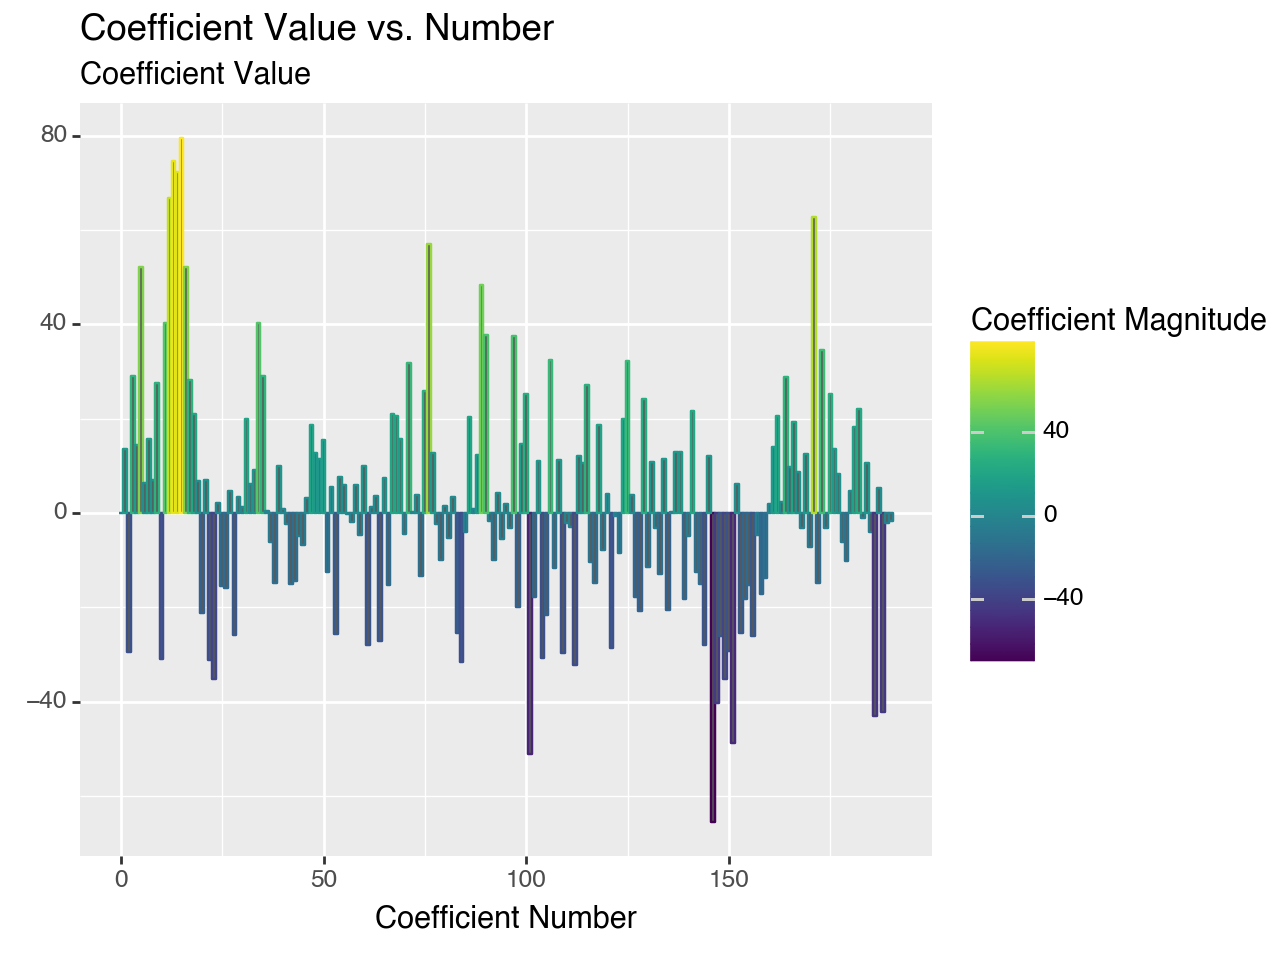

<Figure Size: (640 x 480)>

In [265]:
from plotnine import ggplot, aes, geom_col, labs
coef = fitted_pipeline.named_steps["elastic_net_regression"].coef_
coef = pd.DataFrame(enumerate(coef))
coef.columns = ["Coef #", "Coef Value"]

(ggplot(coef, aes(x = "Coef #", y = "Coef Value", color = "Coef Value")) +
    geom_col() +
    labs(
        x = "Coefficient Number",
        y = "",
        subtitle = "Coefficient Value",
        title = "Coefficient Value vs. Number",
        color = "Coefficient Magnitude"
    ))